# 2025.1119

This notebook analysis Hindcast results variation among 32 samples of w0 with EKF-RNN  
generated by the following program: 
- with Zonal terms, without LOD input:
    - `program_files/2025_1016_learn_derivatives_h34_s0-32_Zonal.py`
    - `program_files/2025_1028_learn_derivatives_h34_s0-32_Zonal_bw.py`
    - `program_files/2025_1030_learn_derivatives_h34_s29_Zonal_d3g.py`
    - `program_files/2025_1031_learn_derivatives_h34_s29_Zonal_d0g.py`
- omnly non-Zonal terms, without LOD input:
    - `program_files/2025_1018_learn_derivatives_h34_s0-32_nonZonal.py`
    - `program_files/2025_1029_learn_derivatives_h34_s0-32_nonZonal_bw.py`
- with LOD input:
    - `program_files/2025_1106_withLOD_h34_s0-32_nonZonal.py`
    - `program_files/2025_1108_withLOD_h34_s0-32_Zonal.py`

for SGEPSS.


Candidate model
- Number of hidden units : `Drec = 34`
- initial $\mathbf{w}_0$ : `seed = best / worst in "00000" - "11111"` (`seed = 29 "11101"` was for IGRF-14)
- Training method : EKF-RNN

`Data Period: MCM-2024 (2004.87〜2024.87)`

- Hindcast experiment (Minami et al., 2020)  
`Train Period: 2004.8739 - 2018.6247 (56 points, 14 yrs )`  
`Valid Period: 2018.8749 - 2023.6254 (20 points, 5 yrs )`  


In [129]:
import platform           # Python 3.9.16
import sys
import re

import numpy      as np   # Numpy 1.23.2
import pandas     as pd   # Pandas 2.0.3
import matplotlib as mpl  # Matplotlib 3.7.1
import seaborn    as sns  # Seaborn 0.12.2

from matplotlib.colors import BoundaryNorm
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

np.set_printoptions(precision=5, floatmode='fixed', suppress=True)
pd.options.display.float_format = '{:.5f}'.format

%matplotlib inline
# print(plt.rcParams.keys())
plt.rcParams.update({
    'font.size'     : 16,
    'axes.grid'     : True,
    'grid.linestyle': '--',
    'lines.linewidth': 2,
})

print(f"Python Platform: {platform.platform()}")
print(f"    Python {sys.version}")
print(f"     Numpy {np.__version__}")
print(f"    Pandas {pd.__version__}")
print(f"Matplotlib {mpl.__version__}")
print(f"   Seaborn {sns.__version__}")

Python Platform: macOS-15.5-arm64-arm-64bit
    Python 3.9.22 | packaged by conda-forge | (main, Apr 14 2025, 23:36:04) 
[Clang 18.1.8 ]
     Numpy 1.23.2
    Pandas 2.1.4
Matplotlib 3.7.1
   Seaborn 0.12.2


In [130]:
### Configuration
mcm_load = "../MCM2024/processed/"

dt = 0.25 # Time step
# d_max = 0-4 # Order of the derivative

Drec = 34 # Dimension of the hidden layer

fS = 2018.8749 # forecast Start time
fE = 2023.6254 # forecast End   time

TS = 2014.1244 + 0.2502 # Jerk at 2015 Start time + leapfrog for SA time
TE = 2017.3739 + 0.2502 # Jerk at 2015 End   time + leapfrog for SA time
TT = 2015.6254 + 0.2502 # Jerk gap peak time      + leapfrog for SA time

IGRF_s = 29

# font size
f_large  = 32
f_medium = 24
f_small  = 18
f_tiny   = 16

sig = 2 # Scale factor for the uncertainty plot (\pm s * sigma)

# Define functions


In [131]:
def get_energy(coef_array, time_array, gnames):
    energy_array = np.zeros((len(time_array), 14), dtype=float) # n==0 is for time

    for i, epoch in enumerate(time_array):
        #- print(epoch)
        energy_array[i, 0] = epoch

        for l, target in enumerate(gnames):
            n = int(target[2:].split(",")[0])

            energy_array[i, n] += (n+1) * coef_array[l, i] * coef_array[l, i]
    
    return energy_array.T

In [132]:
def draw_dP(dg_memo, dg_ref, dR_memo, time_memo, gnames, unit="nT"):
    ### get dP_n(t)

    dP2 = get_energy(dg_memo - dg_ref, time_memo, gnames).T

    # diagR = np.diagonal(dR_memo, axis1=0, axis2=1).T
    dQ2 = get_energy(dR_memo, time_memo, gnames).T

    dP2 = np.delete(dP2, [0], axis=1) # n==0 is time
    dQ2 = np.delete(dQ2, [0], axis=1)
    #- print(dP2)

    dP_df = pd.DataFrame(np.sqrt(dP2), index=time_memo, columns=range(1, 14))

    #- print(dP_df)


    fig, ax = plt.subplots(1, 2, figsize=(12, 9))

    sns.heatmap(dP_df, cmap='jet', norm=LogNorm(vmin=0.01, vmax=100), ax=ax[1])
    ax[1].set_xlabel('SH degree', fontsize=f_medium)
    ax[1].set_yticks(np.arange(1.5, len(time_memo), 4), time_memo[1::4], fontsize=f_tiny)
    ax[1].grid(False)

    dP2sum = np.sum(dP2, axis=1)
    dQ2sum = np.sum(dQ2, axis=1)
    ax[0].plot(np.sqrt(dP2sum), time_memo, c='k', label=r"sqrt(dP)")
    ax[0].plot(np.sqrt(dQ2sum), time_memo, c='k', label=r"sqrt(dQ)", linestyle='dashed')

    #- print(dPend)
    dPend = np.sqrt(dP2sum[-1])
    dQend = np.sqrt(dQ2sum[-1])
    ax[0].text(dPend, time_memo[-1], f"{dPend:.1f} {unit}  ", ha='right',  va='bottom', fontsize=f_large, color='red')
    ax[0].text(dQend, time_memo[-1], f"  {dQend:.1f} {unit}", ha='left',   va='bottom', fontsize=f_small, color='blue')


    ax[0].set_xscale('log')
    ax[0].set_xticks([0.01, 0.1, 1, 10, 100, 1000, 10000])
    ax[0].set_ylim(time_memo[-1], time_memo[0])
    ax[0].set_yticks(time_memo[1::4], time_memo[1::4], fontsize=f_tiny)
    ax[0].set_ylabel('Date (year)\n',                  fontsize=f_medium)

    fig.tight_layout()

    return fig, ax


In [133]:
def remove_zonal_g(g_raw, gname):
    g_nonZonal = g_raw.copy()
    cols_to_drop = []
    for l, col in enumerate(gname):
        # degree n, order m
        match = re.match(r'[gh]\((\d+),(\d+)\)', col)
        if match:
            n = int(match.group(1))
            m = int(match.group(2))
            # print(f"n={n}, m={m}")
            if m == 0:
                cols_to_drop.append(l)
                # print(f"Dropping column: {col}")
    g_nonZonal = np.delete(g_nonZonal, cols_to_drop, axis=0)
    c_nonZonal = [col for i, col in enumerate(gname) if i not in cols_to_drop]
    return g_nonZonal, c_nonZonal

In [134]:
def if_nan_SAgenerate(SA_memo, hindcast, diff):
    CF_time = hindcast['time_memo']
    
    if np.isnan(SA_memo[0, 50]):
        if diff == 0:
            print("  --> NaN found in SA_memo, generating SA from CF series...", end="\n")
            # Generate SA from CF series using finite difference
            CF_memo = hindcast['d0g_memo'] # RNN prediction of Core field
            for i, t in enumerate(CF_time):
                if i in [0, 1, 2]:
                    # print(f"i={i} skipped")
                    continue
                SA_memo[:, i] = (CF_memo[:, i] - 2 * CF_memo[:, i-1] + CF_memo[:, i-2]) / (dt * dt)
            
        elif diff == 1:
            print("  --> NaN found in SA_memo, generating SA from SV series...", end="\n")
            # Generate SA from SV series using finite difference
            SV_memo = hindcast['d1g_memo'] # RNN prediction of SV
            for i, t in enumerate(CF_time):
                if i in [0, 1]:
                    continue
                SA_memo[:, i] = (SV_memo[:, i] - SV_memo[:, i-1]) / dt
        
        else:
            print("  --> NaN found in SA_memo, cannot generate SA from higher derivative orders.", end="\n")
            raise ValueError("SA_memo contains NaN values and cannot be generated.")
        
        return SA_memo
    else:
        return SA_memo

In [135]:
### plot hidden layer output ht
def plot_ht(ht_memo, time_memo, color="black", fontsize=16, fig_ax=None):

    ht_size = ht_memo[:, 0].size

    height = 2.0
    bottom = -1 * height * np.arange(ht_size)

    if fig_ax is not None:
        fig, ax = fig_ax
    else:
        fig, ax = plt.subplots(1, 1, figsize=(12, 16))

    ymin = bottom[-1] - 0.8 * height
    ymax = bottom[0]  + 0.8 * height

    for l in range(ht_size):
        ht_l = ht_memo[l, :]
        ax.plot(time_memo, ht_l + bottom[l], 
                color=color, linewidth=2.0)

    ax.grid(True)
    ax.set_yticks(bottom)
    ax.set_yticklabels([f"$h_{{{l+1}}}$" for l in range(ht_size)], fontsize=fontsize)

    ax.set_ylim(ymin, ymax)
    ax.set_xlabel("Date (year)")
    ax.set_ylabel(r"Hidden Unit Activation")

    return fig, ax

# ちょっと、Zonal成分のresultも含めてプロットしてみる

## Load MCM model


In [136]:
J = 195 # Number of Gauss coefficients up to degree n=13, including zonal terms
print("J =", J)

d0g_raw = pd.read_csv  (f"{mcm_load}/coef_g.csv")  
d1g_raw = pd.read_csv(f"{mcm_load}/coef_d1g.csv")
d2g_raw = pd.read_csv(f"{mcm_load}/coef_d2g.csv")

d0g_raw.set_index('YEAR', inplace=True)
d1g_raw.set_index('YEAR', inplace=True)
d2g_raw.set_index('YEAR', inplace=True)

d0R_raw = np.load  (f"{mcm_load}/cvar_R.npy")  
d1R_raw = np.load(f"{mcm_load}/cvar_d1R.npy")
d2R_raw = np.load(f"{mcm_load}/cvar_d2R.npy")

display(d2g_raw.head())
print(d2R_raw[0:5,0:5, 0])
print(d2R_raw[0:5,0:5, 1])
print(d2R_raw[0:5,0:5, 2])
print(d2R_raw[0:5,0:5, 3])
print(d2R_raw[0:5,0:5, -1])

J = 195


,"g(1,0)","g(1,1)","h(1,1)","g(2,0)","g(2,1)","h(2,1)","g(2,2)","h(2,2)","g(3,0)","g(3,1)",...,"g(18,14)","h(18,14)","g(18,15)","h(18,15)","g(18,16)","h(18,16)","g(18,17)","h(18,17)","g(18,18)","h(18,18)"
YEAR,,,,,,,,,,,,,,,,,,,,,
2004.87390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005.12370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005.37390,-1.30880,2.22560,-0.89280,-0.17440,-0.08800,-0.74240,1.53120,0.15680,-0.06880,0.20320,...,-0.00160,-0.00000,-0.00000,-0.00000,0.00160,0.00000,0.00160,0.00000,0.00160,-0.00160
2005.62410,-0.00000,1.10080,-0.70560,0.47520,-0.55680,-0.27360,1.43360,0.30720,-0.10240,-0.53280,...,0.00160,0.00000,0.00000,0.00000,-0.00160,-0.00000,-0.00160,-0.00160,-0.00160,0.00160
2005.87420,-0.78560,1.80640,-1.30880,0.81440,-0.77440,-0.56000,2.16160,1.32000,0.09280,0.14880,...,-0.00160,-0.00000,-0.00160,-0.00160,0.00000,0.00160,0.00000,0.00160,0.00000,-0.00000


[[2004.87400        nan        nan        nan        nan]
 [       nan        nan        nan        nan        nan]
 [       nan        nan        nan        nan        nan]
 [       nan        nan        nan        nan        nan]
 [       nan        nan        nan        nan        nan]]
[[2005.12400        nan        nan        nan        nan]
 [       nan        nan        nan        nan        nan]
 [       nan        nan        nan        nan        nan]
 [       nan        nan        nan        nan        nan]
 [       nan        nan        nan        nan        nan]]
[[2005.37400        nan        nan        nan        nan]
 [       nan   36.30865   -0.34635   -0.11209    1.66008]
 [       nan   -0.34635   20.52914   -0.11124   -0.04573]
 [       nan   -0.11209   -0.11124   25.27605    0.14777]
 [       nan    1.66008   -0.04573    0.14777   18.48007]]
[[2005.62400        nan        nan        nan        nan]
 [       nan   36.29873   -0.34612   -0.11215    1.66007]
 [       na

In [137]:
coef_raw    = [d0g_raw.iloc[:, :J], d1g_raw.iloc[:, :J], d2g_raw.iloc[:, :J]]
Rmatrix_raw = [d0R_raw[:J+1, :J+1, :], d1R_raw[:J+1, :J+1, :], d2R_raw[:J+1, :J+1, :]]

col_raw = coef_raw[0].columns.tolist()
time_raw = coef_raw[0].index.values

print(col_raw)
print(time_raw)
print(d0R_raw[0, 0, :])

['g(1,0)', 'g(1,1)', 'h(1,1)', 'g(2,0)', 'g(2,1)', 'h(2,1)', 'g(2,2)', 'h(2,2)', 'g(3,0)', 'g(3,1)', 'h(3,1)', 'g(3,2)', 'h(3,2)', 'g(3,3)', 'h(3,3)', 'g(4,0)', 'g(4,1)', 'h(4,1)', 'g(4,2)', 'h(4,2)', 'g(4,3)', 'h(4,3)', 'g(4,4)', 'h(4,4)', 'g(5,0)', 'g(5,1)', 'h(5,1)', 'g(5,2)', 'h(5,2)', 'g(5,3)', 'h(5,3)', 'g(5,4)', 'h(5,4)', 'g(5,5)', 'h(5,5)', 'g(6,0)', 'g(6,1)', 'h(6,1)', 'g(6,2)', 'h(6,2)', 'g(6,3)', 'h(6,3)', 'g(6,4)', 'h(6,4)', 'g(6,5)', 'h(6,5)', 'g(6,6)', 'h(6,6)', 'g(7,0)', 'g(7,1)', 'h(7,1)', 'g(7,2)', 'h(7,2)', 'g(7,3)', 'h(7,3)', 'g(7,4)', 'h(7,4)', 'g(7,5)', 'h(7,5)', 'g(7,6)', 'h(7,6)', 'g(7,7)', 'h(7,7)', 'g(8,0)', 'g(8,1)', 'h(8,1)', 'g(8,2)', 'h(8,2)', 'g(8,3)', 'h(8,3)', 'g(8,4)', 'h(8,4)', 'g(8,5)', 'h(8,5)', 'g(8,6)', 'h(8,6)', 'g(8,7)', 'h(8,7)', 'g(8,8)', 'h(8,8)', 'g(9,0)', 'g(9,1)', 'h(9,1)', 'g(9,2)', 'h(9,2)', 'g(9,3)', 'h(9,3)', 'g(9,4)', 'h(9,4)', 'g(9,5)', 'h(9,5)', 'g(9,6)', 'h(9,6)', 'g(9,7)', 'h(9,7)', 'g(9,8)', 'h(9,8)', 'g(9,9)', 'h(9,9)', 'g(10,0)'

In [138]:
print(TT)
TT_idx = np.abs(time_raw - TT).argmin()
TT = time_raw[TT_idx]

print(f"target_epoch = {TT}")
CF_ref = coef_raw[0].loc[TT, :].values.T # Reference CF at target_epoch
SV_ref = coef_raw[1].loc[TT, :].values.T # Reference SV at target_epoch
SA_ref = coef_raw[2].loc[TT, :].values.T # Reference SA at target_epoch
TG_ref = SA_ref.reshape(-1, 1) # target field
print(TG_ref.shape, "\n", TG_ref[:5])

2015.8755999999998
target_epoch = 2015.8756
(195, 1) 
 [[-1.30720]
 [-4.02880]
 [-2.77600]
 [ 0.51520]
 [-1.68960]]


In [139]:
yZyZ_nLOD_SAddP = pd.DataFrame(index=np.arange(0, 5), columns=np.arange(0, 32), dtype=float)
save_dir = "./trained_models/2025_1017_Zonal"

for d_max in range(5):
    for seed in range(0, 32):
        b_seed = format(seed, '05b') # seed No. as 5-bit binary

        filename = f"d{d_max}g_{Drec}_{b_seed}_geomag_memos.npz"

        read_file = f".{save_dir}/{filename}"

        print(f"reading {(d_max, Drec, b_seed)}: ", end="")

        pred_memos = np.load(read_file, allow_pickle=True)
        print(f"loaded --> ", end="\n")
        
        CF_time = pred_memos['time_memo']   # time - leap frog
        CF_cols = pred_memos['columns'][:J] # target field columns
        SA_memo = pred_memos['d2g_memo'] # RNN prediction of SA

        SA_memo = if_nan_SAgenerate(SA_memo, pred_memos, diff=d_max)

        TG_memo = SA_memo[:J, :] # target field

        print(f"time={CF_time.shape}, shape={TG_memo.shape} --> ", end="")

        # t_idx = np.where(CF_time == target_epoch)[0][0]
        # print(f"t_idx={fE_idx} --> ", end="")

        # 範囲インデックス配列の作成
        # tS_idx = np.abs(CF_time - TS).argmin()
        # tE_idx = np.abs(CF_time - TE).argmin()
        # t_indices = np.arange(tS_idx, tE_idx + 1)
        
        t_idx = np.abs(CF_time - TT).argmin()
        t_indices = [t_idx]
        print(f"t_indices from {t_indices[0]} to {t_indices[-1]} ({len(t_indices)} points) --> ", end="")

        TG_rnn = TG_memo[:, t_indices] # multiple time steps
        error = TG_rnn - TG_ref
        print("error.shape: ", error.shape, len(CF_cols), "--> ", end="")
        
        ddP2 = get_energy(error, CF_time[t_indices], CF_cols)
        # print("ddP2:", ddP2)
        print("ddP2.shape", ddP2.shape, len(CF_cols), "--> ", end="")
        #sqrtddP = np.sqrt(np.trapz(ddP2[1:, :].sum(axis=0), CF_time[t_indices])) # integrate over time
        sqrtddP = np.sqrt(ddP2[1:, :].sum())

        print(f"sqrt(ddP)={sqrtddP:.4f} nT --> ", end="")
        yZyZ_nLOD_SAddP.loc[d_max, seed] = sqrtddP

        print("ddP table done", end="\n")


reading (0, 34, '00000'): loaded --> 
  --> NaN found in SA_memo, generating SA from CF series...
time=(76,), shape=(195, 76) --> t_indices from 44 to 44 (1 points) --> error.shape:  (195, 1) 195 --> ddP2.shape (14, 1) 195 --> sqrt(ddP)=9.3734 nT --> ddP table done
reading (0, 34, '00001'): loaded --> 
  --> NaN found in SA_memo, generating SA from CF series...
time=(76,), shape=(195, 76) --> t_indices from 44 to 44 (1 points) --> error.shape:  (195, 1) 195 --> ddP2.shape (14, 1) 195 --> sqrt(ddP)=9.3734 nT --> ddP table done
reading (0, 34, '00010'): loaded --> 
  --> NaN found in SA_memo, generating SA from CF series...
time=(76,), shape=(195, 76) --> t_indices from 44 to 44 (1 points) --> error.shape:  (195, 1) 195 --> ddP2.shape (14, 1) 195 --> sqrt(ddP)=9.3734 nT --> ddP table done
reading (0, 34, '00011'): loaded --> 
  --> NaN found in SA_memo, generating SA from CF series...
time=(76,), shape=(195, 76) --> t_indices from 44 to 44 (1 points) --> error.shape:  (195, 1) 195 --> dd

In [140]:
display(yZyZ_nLOD_SAddP.T)
display(yZyZ_nLOD_SAddP.T.describe())

,0,1,2,3,4
0,9.37341,11.37588,3.72983,2.60338,10.35589
1,9.37341,90.80010,1.79349,2.90875,10.27732
2,9.37341,12.78696,2.82009,2.92037,10.19538
3,9.37341,2.05463,4.10582,3.60493,10.10093
4,9.37341,7.61503,3.20381,2.87456,10.13234
5,9.37341,3.26200,3.71982,3.00812,10.16038
6,9.37341,2.48949,4.58034,3.30582,10.10422
7,9.37341,9.69273,3.89015,2.75472,10.21156
8,9.37341,9.64242,4.46521,3.10045,10.23009
9,9.37341,9.53117,3.31259,3.11336,10.06104


,0,1,2,3,4
count,32.00000,32.00000,32.00000,32.00000,32.00000
mean,9.37341,15.96319,3.49928,3.10105,10.19167
std,0.00000,28.51078,0.76096,0.30689,0.12007
min,9.37341,0.21513,1.79349,2.60338,9.87526
25%,9.37341,5.05675,3.14856,2.90797,10.10340
50%,9.37341,9.52930,3.45357,3.08914,10.19721
75%,9.37341,10.11352,3.76991,3.23649,10.28272
max,9.37341,145.37193,5.05873,4.12030,10.41479


  --> NaN found in SA_memo, generating SA from CF series...


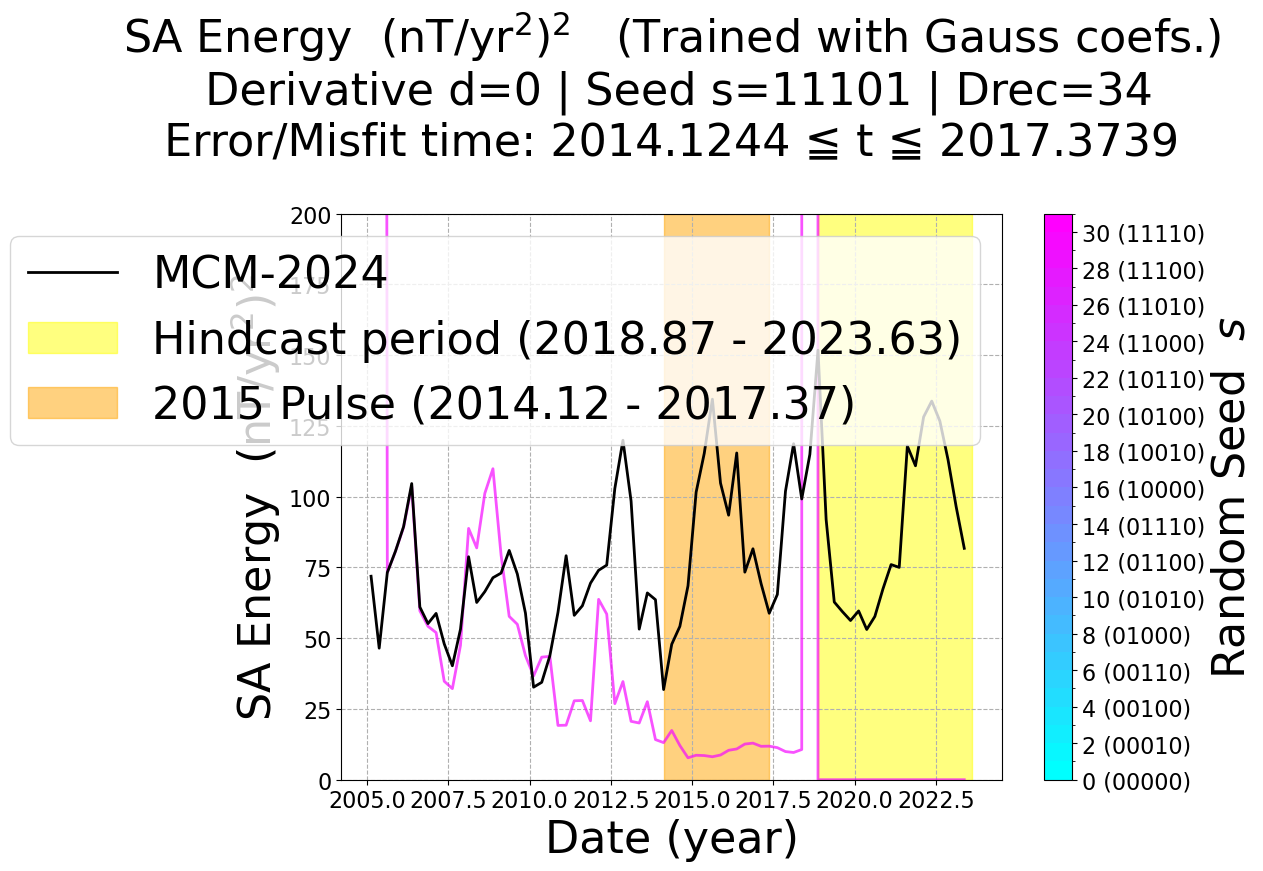

  --> NaN found in SA_memo, generating SA from SV series...


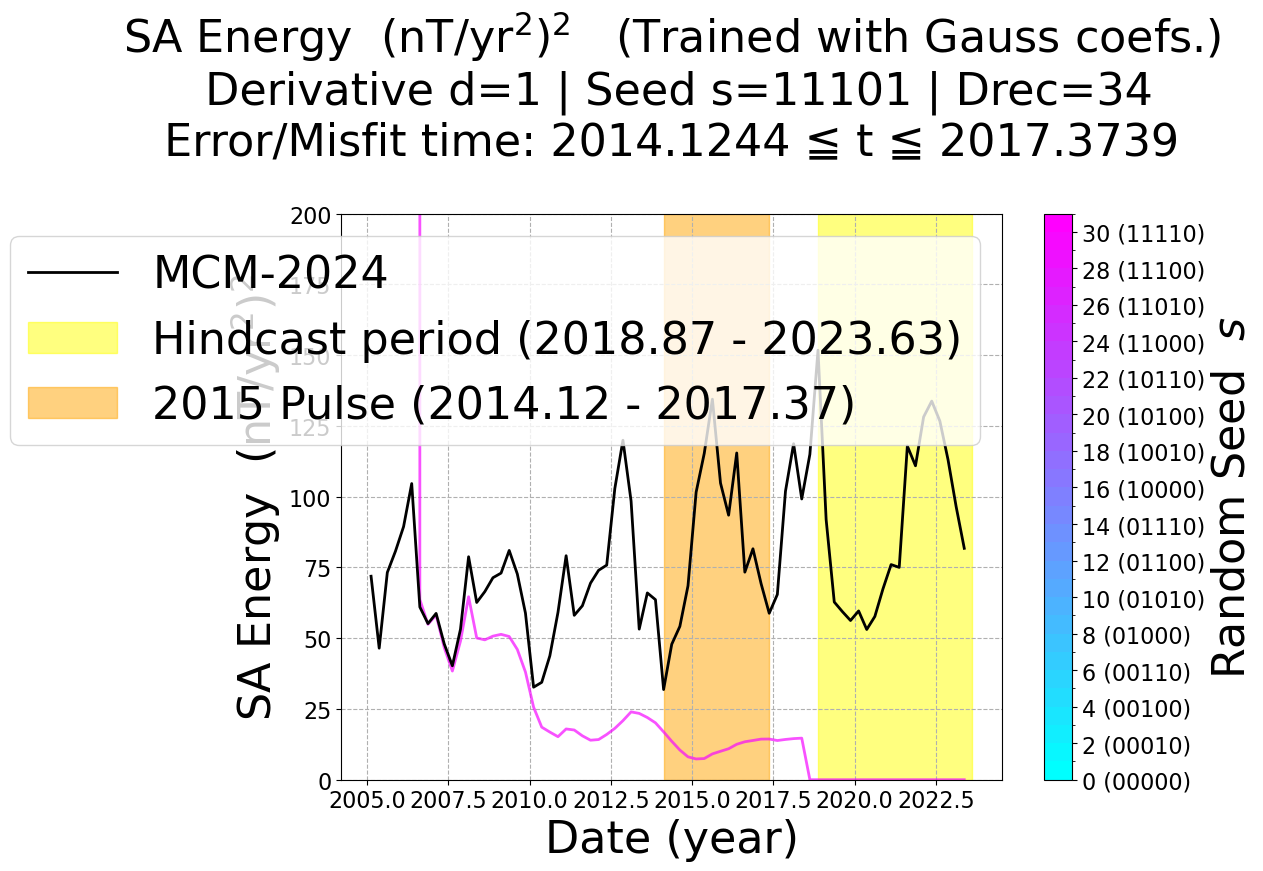

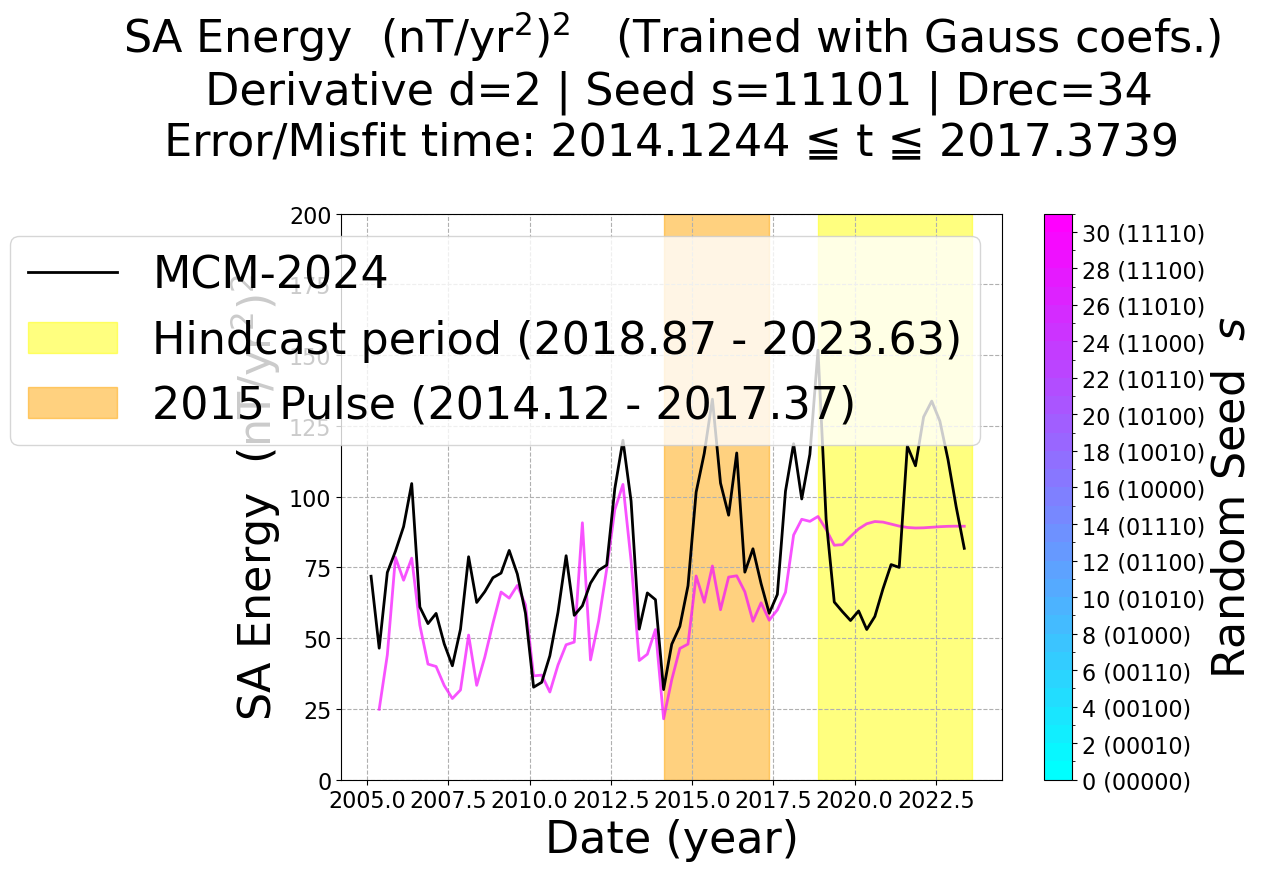

In [141]:
# plot SA Energy series for s=29
plot_table = yZyZ_nLOD_SAddP

for diff in [0, 1, 2]:

    fig, ax = plt.subplots(1, 1, figsize=(12, 9))

    cmap = mpl.colormaps['cool']
    norm = BoundaryNorm(plot_table.columns, cmap.N)
    seed_l = plot_table.columns[0:31:2]

    for s in [29]:
        b_seed = format(s, '05b')
        hindcast = np.load(f".{save_dir}/d{diff}g_{Drec}_{b_seed}_geomag_memos.npz", allow_pickle=True)

        SA_time = hindcast['time_memo'] - 0.2502  # adjust time for SA leapfrog
        SA_memo = hindcast['d2g_memo'] # RNN prediction of SA

        SA_memo = if_nan_SAgenerate(SA_memo, hindcast, diff=diff)

        SA_Energy_col = get_energy(SA_memo[:J, :], SA_time, hindcast['columns'][:J])
        SA_Energy_tot = SA_Energy_col[1:, :].sum(axis=0)

        # print(SA_Energy_col[0, :], SA_Energy_tot)

        ax.plot(SA_Energy_col[0, :], SA_Energy_tot, 
                c=cmap(norm(s)), alpha=0.7)


    SA_ref = coef_raw[2].loc[hindcast['time_memo'], :].values.T # Reference SA time series
    SA_Energy_ref_col = get_energy(SA_ref, hindcast['time_memo'] - 0.2502, hindcast['columns'][:J])
    SA_Energy_ref_tot = SA_Energy_ref_col[1:, :].sum(axis=0)
    ax.plot(SA_Energy_ref_col[0, :], SA_Energy_ref_tot, c='black', label='MCM-2024')


    p = ax.scatter([np.nan]*32, [np.nan]*32, cmap=cmap, norm=norm, c=range(32), alpha=1.0, marker='none')
    ax.colorbar = plt.colorbar(p, ax=ax)
    ax.colorbar.set_label(r"Random Seed  $s$", fontsize=f_large)
    # print([f"{seed} ({format(seed, '05b')})" for seed in seed_l])
    ax.colorbar.set_ticks                                                    (seed_l)
    ax.colorbar.set_ticklabels([f"{seed} ({format(seed, '05b')})" for seed in seed_l])


    ymin, ymax = 0, 200
    ax.set_ylim(ymin, ymax)

    ax.fill_between(hindcast['time_memo'], ymin, ymax, 
                    where=(hindcast['time_memo']>=fS) & (hindcast['time_memo']<=fE), 
                    color='yellow', alpha=0.5, label=f'Hindcast period ({fS:.2f} - {fE:.2f})')
    ax.fill_between(hindcast['time_memo'], ymin, ymax, 
                    where=(hindcast['time_memo']>=TS-0.2502) & (hindcast['time_memo']<=TE-0.2502), 
                    color='orange', alpha=0.5, label=f'2015 Pulse ({TS-0.25:.2f} - {TE-0.25:.2f})')

    ax.set_xlabel('Date (year)', fontsize=f_large)
    ax.set_ylabel(r"SA Energy  (nT/yr$^2$)$^2$", fontsize=f_large)
    ax.set_title(r"SA Energy  (nT/yr$^2$)$^2$   (Trained with Gauss coefs.)" + 
                f"\n Derivative d={diff} | Seed s=11101 | Drec=34" + 
                f"\n Error/Misfit time: {TS-0.2502:.4f} ≦ t ≦ {TE-0.2502:.4f} \n", 
                fontsize=f_large)
    ax.legend(fontsize=f_large)
    plt.tight_layout()
    plt.show()

In [142]:
### Compute ddP table
yZyZ_yLOD_SAddP = pd.DataFrame(index=np.arange(0, 5), columns=np.arange(0, 32), dtype=float)

save_dir = "./trained_models/2025_1108_LODZonal"
for d_max in range(5):
    for seed in range(0, 32):
        b_seed = format(seed, '05b') # seed No. as 5-bit binary

        filename = f"d{d_max}g_{Drec}_{b_seed}_geomag_memos.npz"

        read_file = f".{save_dir}/{filename}"

        print(f"reading {(d_max, Drec, b_seed)}: ", end="")

        try:
            pred_memos = np.load(read_file, allow_pickle=True)
        except Exception as e:
            print(f"Error loading {read_file}: {e}")
            continue
        
        print(f"loaded --> ", end="\n")
        
        CF_time = pred_memos['time_memo']       # time - leap frog
        CF_cols = pred_memos['columns'][:J]   # target field columns, exclude LOD at the end
        SA_memo = pred_memos['d2g_memo']        # RNN prediction of SA

        SA_memo = if_nan_SAgenerate(SA_memo, pred_memos, diff=d_max)

        TG_memo = SA_memo[:J, :] # target field (exclude LOD at the end)

        print(f"time={CF_time.shape}, shape={TG_memo.shape} --> ", end="")

        # t_idx = np.where(CF_time == target_epoch)[0][0]
        # print(f"t_idx={fE_idx} --> ", end="")

        # 範囲インデックス配列の作成
        # tS_idx = np.abs(CF_time - TS).argmin()
        # tE_idx = np.abs(CF_time - TE).argmin()
        # t_indices = np.arange(tS_idx, tE_idx + 1)

        t_idx = np.abs(CF_time - TT).argmin()
        t_indices = [t_idx]
        print(f"t_indices from {t_indices[0]} to {t_indices[-1]} ({len(t_indices)} points) --> ", end="")

        TG_rnn = TG_memo[:, t_indices] # multiple time steps
        error  = TG_rnn - TG_ref
        print("error.shape: ", error.shape, len(CF_cols), "--> ", end="")
        
        ddP2 = get_energy(error, CF_time[t_indices], CF_cols)
        # print("ddP2:", ddP2)
        print("ddP2.shape", ddP2.shape, len(CF_cols), "--> ", end="")
        # sqrtddP = np.sqrt(np.trapz(ddP2[1:, :].sum(axis=0), CF_time[t_indices])) # integrate over time
        sqrtddP = np.sqrt(ddP2[1:, :].sum()) # integrate over time

        print(f"sqrt(ddP)={sqrtddP:.4f} nT --> ", end="")
        yZyZ_yLOD_SAddP.loc[d_max, seed] = sqrtddP

        print("ddP table done", end="\n")


reading (0, 34, '00000'): loaded --> 
  --> NaN found in SA_memo, generating SA from CF series...
time=(76,), shape=(195, 76) --> t_indices from 44 to 44 (1 points) --> error.shape:  (195, 1) 195 --> ddP2.shape (14, 1) 195 --> sqrt(ddP)=9.3734 nT --> ddP table done
reading (0, 34, '00001'): loaded --> 
  --> NaN found in SA_memo, generating SA from CF series...
time=(76,), shape=(195, 76) --> t_indices from 44 to 44 (1 points) --> error.shape:  (195, 1) 195 --> ddP2.shape (14, 1) 195 --> sqrt(ddP)=9.3734 nT --> ddP table done
reading (0, 34, '00010'): loaded --> 
  --> NaN found in SA_memo, generating SA from CF series...
time=(76,), shape=(195, 76) --> t_indices from 44 to 44 (1 points) --> error.shape:  (195, 1) 195 --> ddP2.shape (14, 1) 195 --> sqrt(ddP)=9.3734 nT --> ddP table done
reading (0, 34, '00011'): loaded --> 
  --> NaN found in SA_memo, generating SA from CF series...
time=(76,), shape=(195, 76) --> t_indices from 44 to 44 (1 points) --> error.shape:  (195, 1) 195 --> dd

In [143]:
display(yZyZ_yLOD_SAddP.T)
display(yZyZ_yLOD_SAddP.T.describe())

,0,1,2,3,4
0,9.37341,0.17052,2.94184,3.02514,10.05805
1,9.37341,35.17073,3.07143,2.96271,9.98440
2,9.37341,10.18920,4.04763,3.36740,10.06597
3,9.37341,5.81178,2.13161,3.14634,10.24554
4,9.37341,2.25806,3.51207,2.84785,10.24132
5,9.37341,2.58260,3.19350,2.96552,10.28083
6,9.37341,247.81582,5.62161,3.03014,9.94717
7,9.37341,9.69270,5.36600,3.17975,10.19725
8,9.37341,4.21928,2.80989,3.59257,10.40138
9,9.37341,22.67957,2.75293,3.56091,10.30179


,0,1,2,3,4
count,15.00000,15.00000,15.00000,14.00000,14.00000
mean,9.37341,24.77057,3.41828,3.19003,10.16578
std,0.00000,62.37138,0.96655,0.29725,0.14425
min,9.37341,0.17052,2.13161,2.84785,9.94717
25%,9.37341,3.40094,2.87586,2.98043,10.06003
50%,9.37341,6.23680,3.19350,3.08902,10.18150
75%,9.37341,9.94095,3.55243,3.33633,10.27201
max,9.37341,247.81582,5.62161,3.83436,10.40138


  --> NaN found in SA_memo, generating SA from CF series...


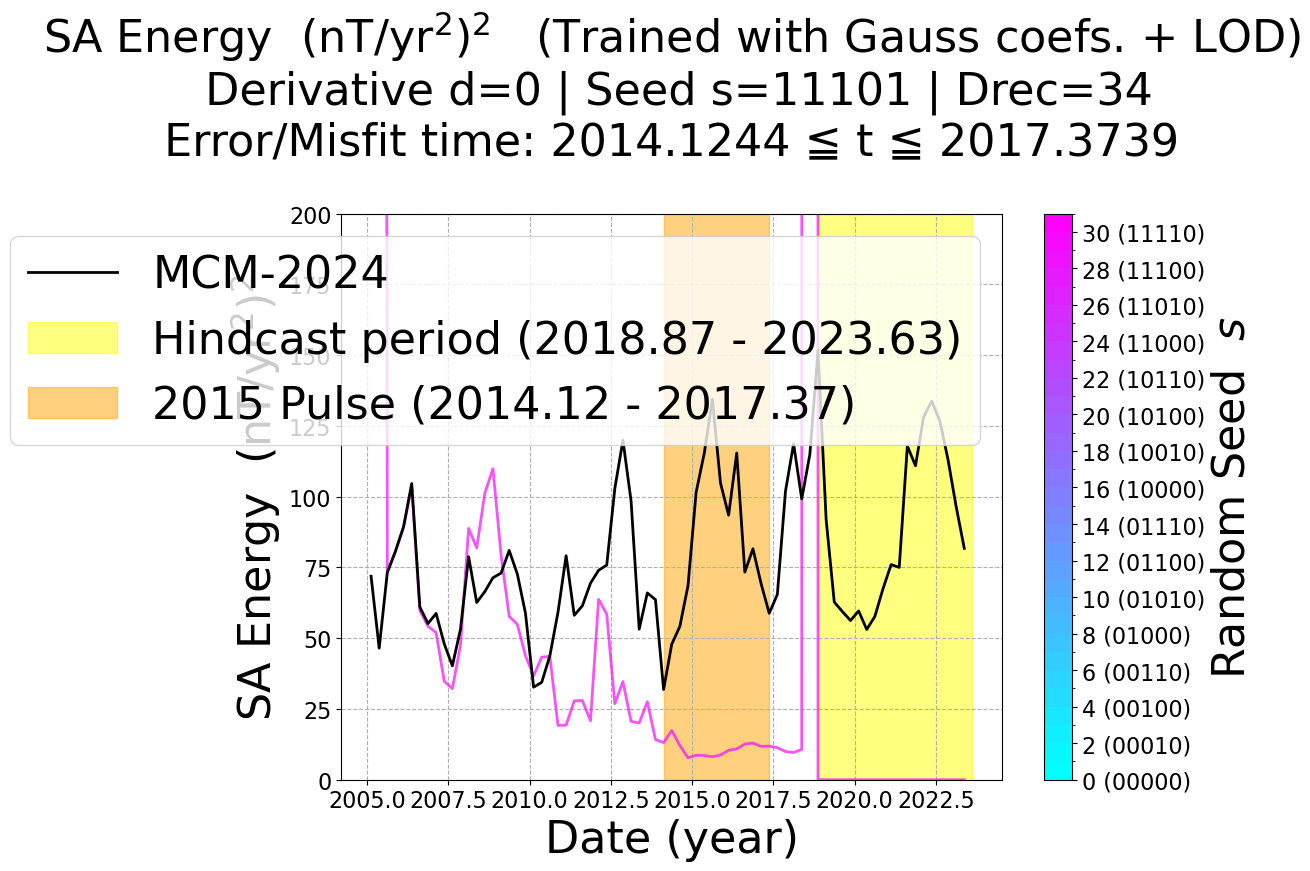

  --> NaN found in SA_memo, generating SA from SV series...


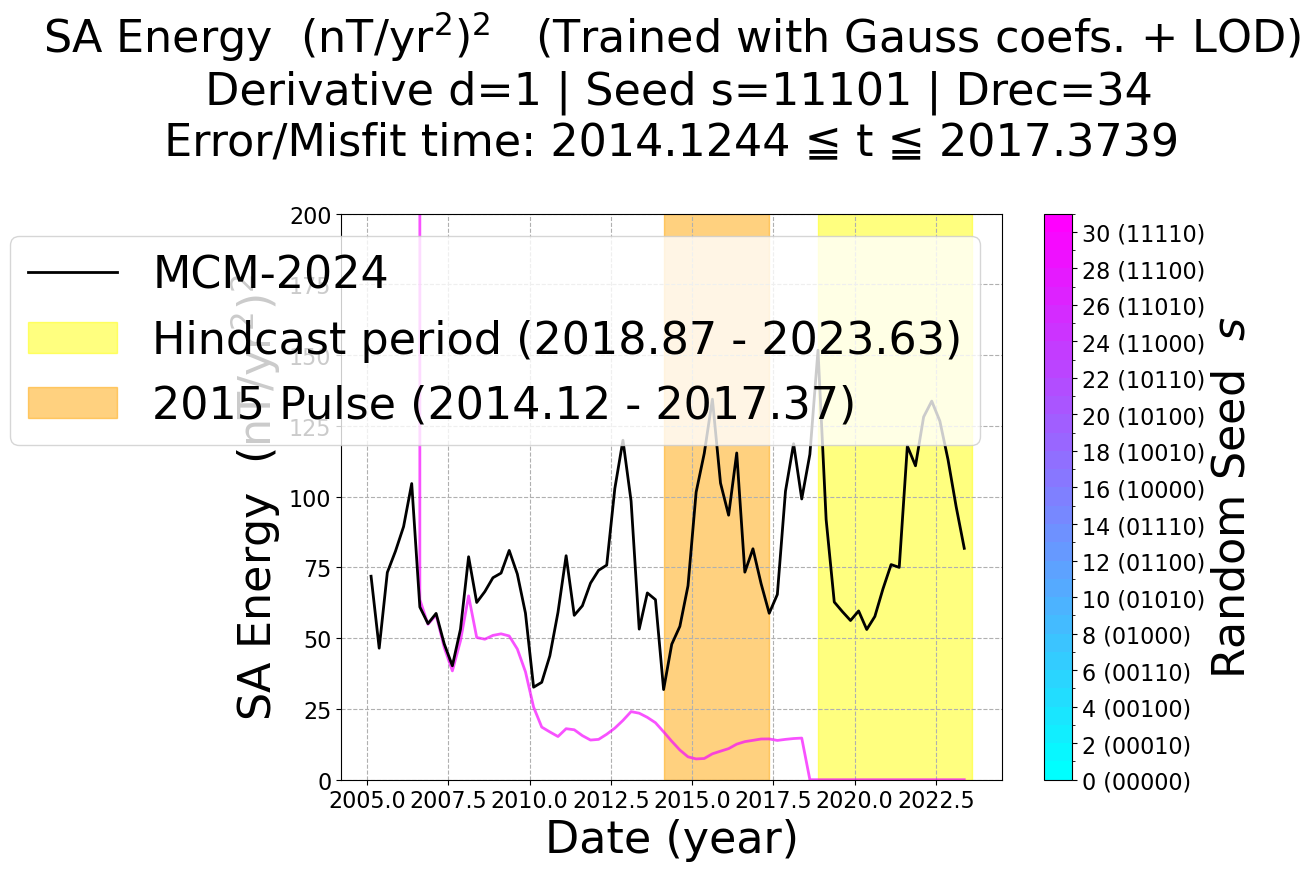

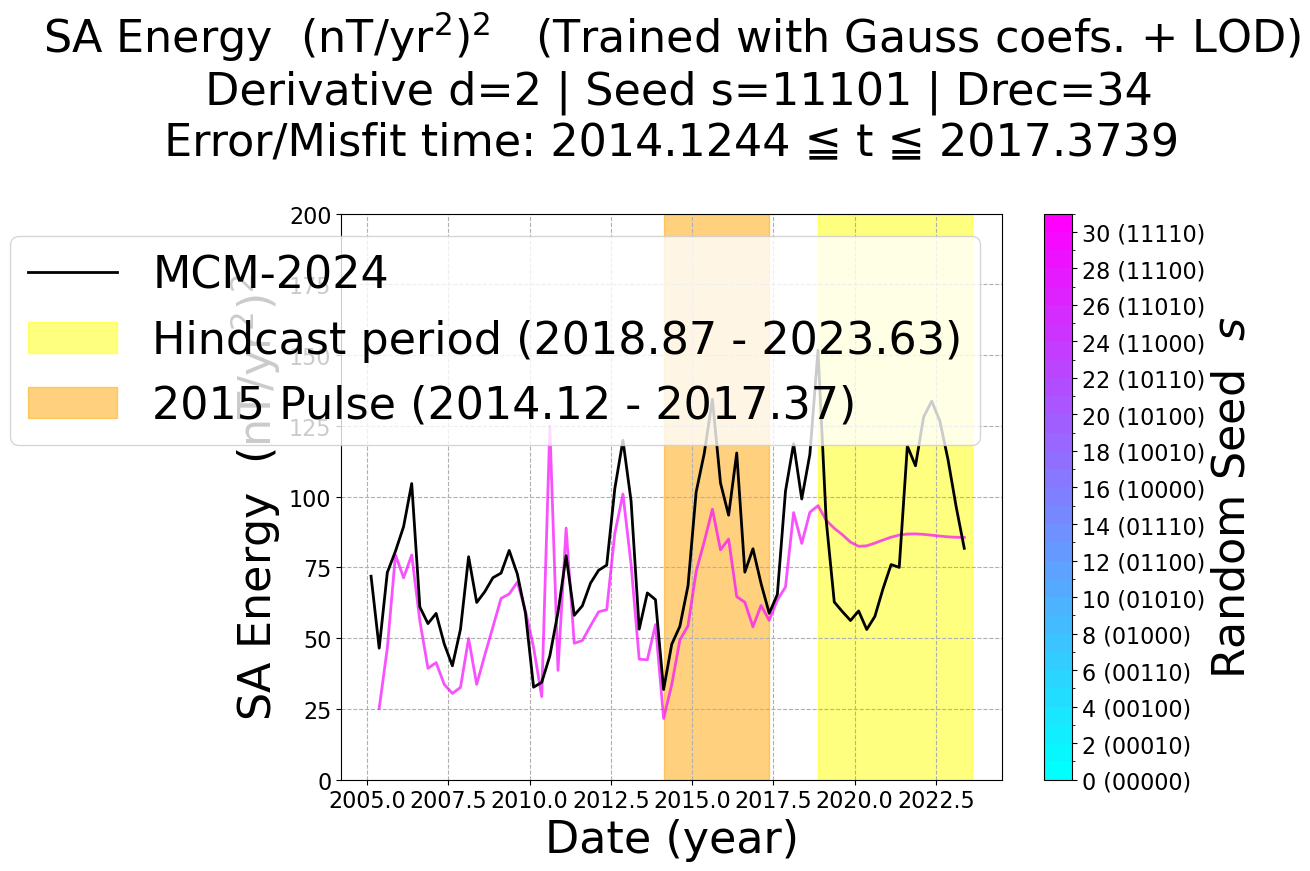

In [144]:
# plot SA Energy series for s=29
plot_table = yZyZ_yLOD_SAddP

for diff in [0, 1, 2]:

    fig, ax = plt.subplots(1, 1, figsize=(12, 9))

    cmap = mpl.colormaps['cool']
    norm = BoundaryNorm(plot_table.columns, cmap.N)
    seed_l = plot_table.columns[0:31:2]

    for s in [29]:
        b_seed = format(s, '05b')
        hindcast = np.load(f".{save_dir}/d{diff}g_{Drec}_{b_seed}_geomag_memos.npz", allow_pickle=True)

        SA_time = hindcast['time_memo'] - 0.2502  # adjust time for SA leapfrog
        SA_memo = hindcast['d2g_memo'] # RNN prediction of SA

        SA_memo = if_nan_SAgenerate(SA_memo, hindcast, diff=diff)

        SA_Energy_col = get_energy(SA_memo[:J, :], SA_time, hindcast['columns'][:J])
        SA_Energy_tot = SA_Energy_col[1:, :].sum(axis=0)

        # print(SA_Energy_col[0, :], SA_Energy_tot)

        ax.plot(SA_Energy_col[0, :], SA_Energy_tot, 
                c=cmap(norm(s)), alpha=0.7)


    SA_ref = coef_raw[2].loc[hindcast['time_memo'], :].values.T # Reference SA time series
    SA_Energy_ref_col = get_energy(SA_ref, hindcast['time_memo'] - 0.2502, hindcast['columns'][:J])
    SA_Energy_ref_tot = SA_Energy_ref_col[1:, :].sum(axis=0)
    ax.plot(SA_Energy_ref_col[0, :], SA_Energy_ref_tot, c='black', label='MCM-2024')


    p = ax.scatter([np.nan]*32, [np.nan]*32, cmap=cmap, norm=norm, c=range(32), alpha=1.0, marker='none')
    ax.colorbar = plt.colorbar(p, ax=ax)
    ax.colorbar.set_label(r"Random Seed  $s$", fontsize=f_large)
    # print([f"{seed} ({format(seed, '05b')})" for seed in seed_l])
    ax.colorbar.set_ticks                                                    (seed_l)
    ax.colorbar.set_ticklabels([f"{seed} ({format(seed, '05b')})" for seed in seed_l])


    ymin, ymax = 0, 200
    ax.set_ylim(ymin, ymax)

    ax.fill_between(hindcast['time_memo'], ymin, ymax, 
                    where=(hindcast['time_memo']>=fS) & (hindcast['time_memo']<=fE), 
                    color='yellow', alpha=0.5, label=f'Hindcast period ({fS:.2f} - {fE:.2f})')
    ax.fill_between(hindcast['time_memo'], ymin, ymax, 
                    where=(hindcast['time_memo']>=TS-0.2502) & (hindcast['time_memo']<=TE-0.2502), 
                    color='orange', alpha=0.5, label=f'2015 Pulse ({TS-0.25:.2f} - {TE-0.25:.2f})')

    ax.set_xlabel('Date (year)', fontsize=f_large)
    ax.set_ylabel(r"SA Energy  (nT/yr$^2$)$^2$", fontsize=f_large)
    ax.set_title(r"SA Energy  (nT/yr$^2$)$^2$   (Trained with Gauss coefs. + LOD)" + 
                f"\n Derivative d={diff} | Seed s=11101 | Drec=34" + 
                f"\n Error/Misfit time: {TS-0.2502:.4f} ≦ t ≦ {TE-0.2502:.4f} \n", 
                fontsize=f_large)
    ax.legend(fontsize=f_large)
    plt.tight_layout()
    plt.show()

## SA time series plot

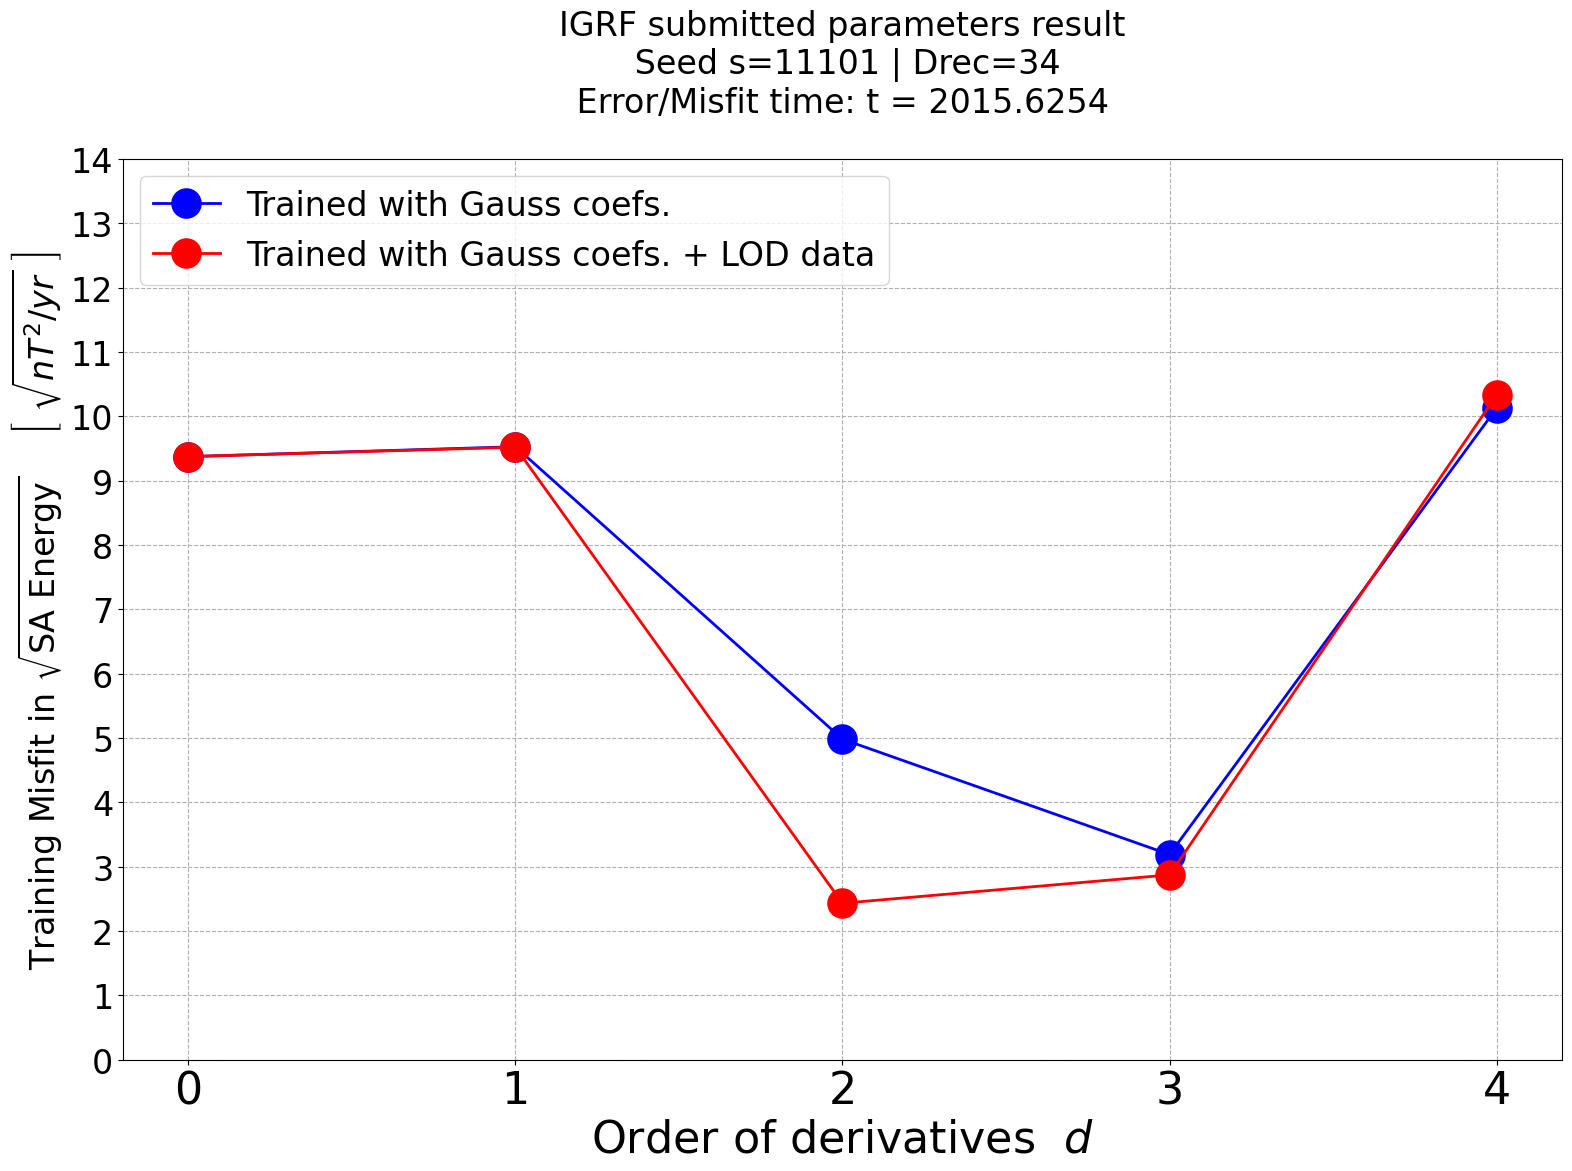

In [152]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))

ax.plot(yZyZ_nLOD_SAddP.index, yZyZ_nLOD_SAddP.loc[:, IGRF_s].values, 
        marker="o", markersize=20, markeredgewidth=2, linestyle="-", linewidth=2.0, color="blue", 
        markerfacecolor='blue', markeredgecolor='blue', 
        label="Trained with Gauss coefs.")

ax.plot(yZyZ_yLOD_SAddP.index, yZyZ_yLOD_SAddP.loc[:, IGRF_s].values, 
        marker="o", markersize=20, markeredgewidth=2, linestyle="-", linewidth=2.0, color="red", 
        markerfacecolor='red', markeredgecolor='red', 
        label="Trained with Gauss coefs. + LOD data")

ax.set_xticks(range(5))
ax.tick_params(axis='x', labelsize=f_large)
ax.set_yticks(range(15))
ax.set_ylim(0, 14)
ax.tick_params(axis='y', labelsize=f_medium)
# ax.set_yscale('log')
ax.set_xlabel(r"Order of derivatives  $d$", fontsize=f_large)
ax.set_ylabel(r"Training Misfit in $\sqrt{\mathrm{SA \ Energy}}$    $\left[ \ \sqrt{nT^2/yr} \ \right]$", fontsize=f_medium)

ax.set_title(f"IGRF submitted parameters result" + 
             "\n Seed s=11101 | Drec=34" + 
             f"\n Error/Misfit time: t = {TT-0.2502:.4f} \n", 
             fontsize=f_medium)
plt.legend(fontsize=f_medium, loc='upper left')
plt.tight_layout()
plt.show()

Plotting for d=2, s=29 (11101)


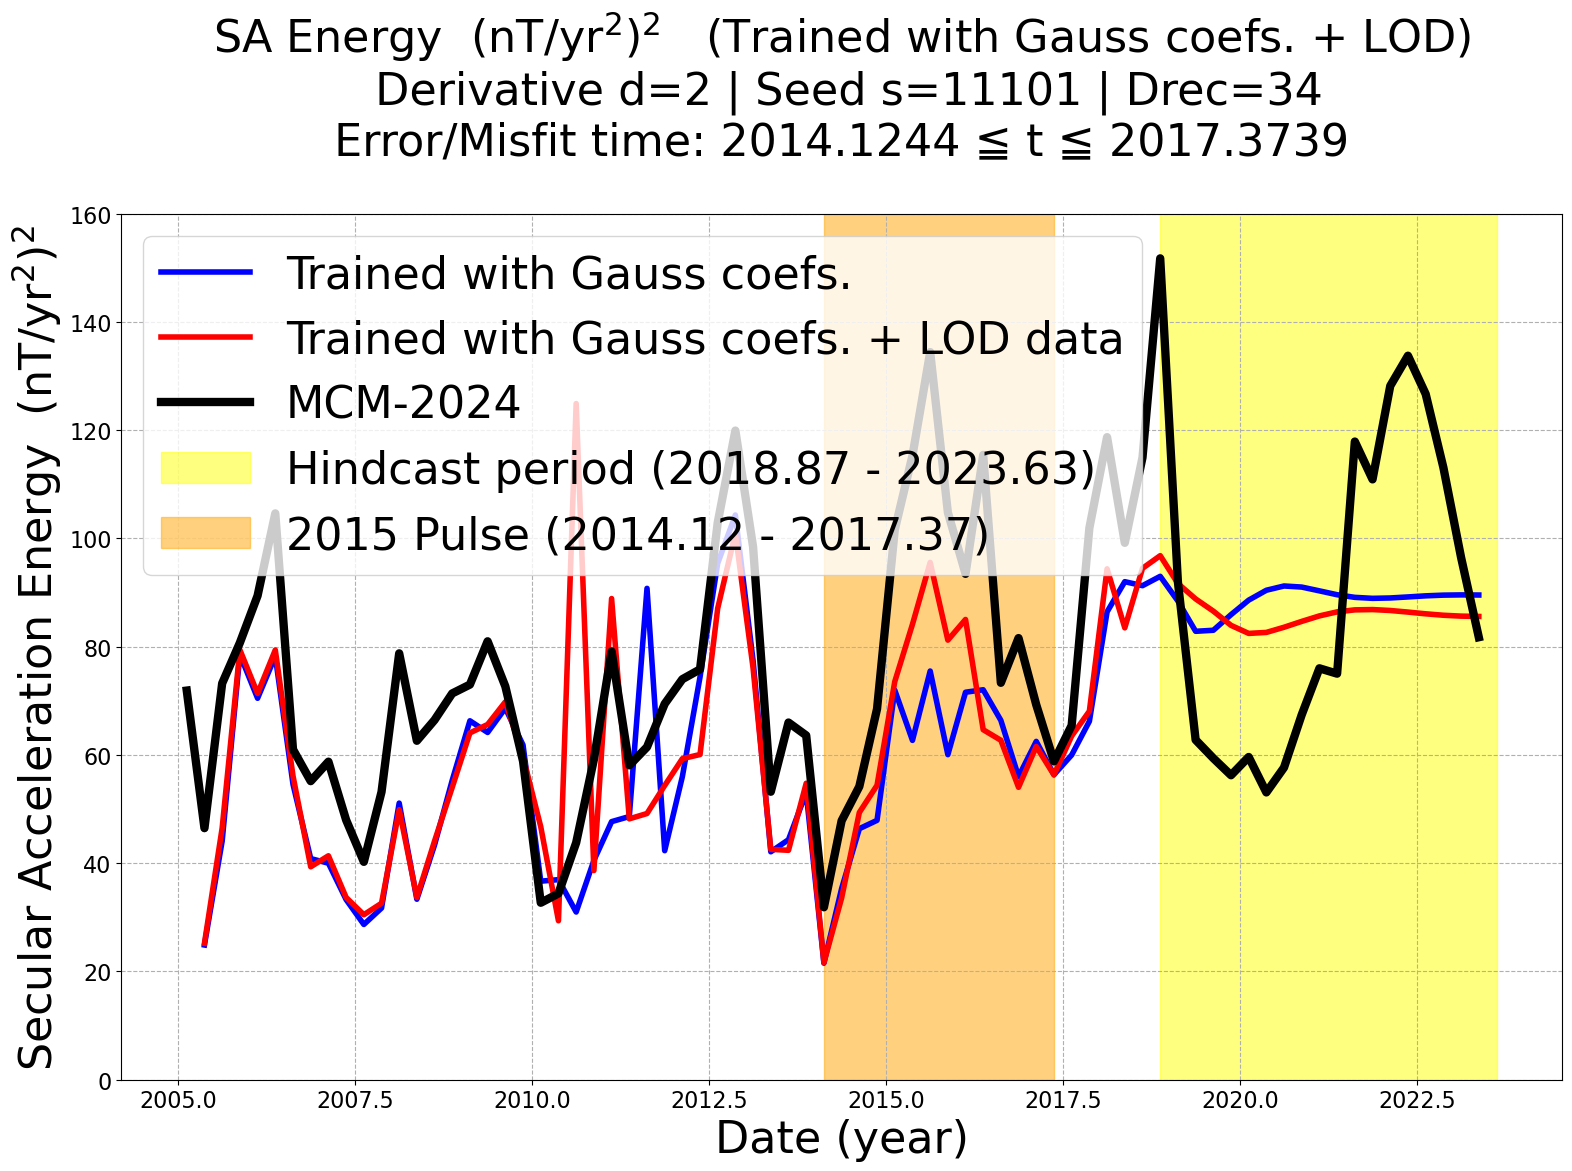

In [146]:
# plot SA Energy series for s=29
diff = 2
s = 29
b_seed = format(s, '05b')
print(f"Plotting for d={diff}, s={s} ({b_seed})")

fig, ax = plt.subplots(1, 1, figsize=(16, 12))

## Trained without LOD ----------------------------------
nLOD = np.load(f"../trained_models/2025_1017_Zonal/d{diff}g_{Drec}_{b_seed}_geomag_memos.npz", allow_pickle=True)

nLOD_SA_time = nLOD['time_memo'] - 0.2502  # adjust time for SA leapfrog
nLOD_SA_memo = nLOD['d2g_memo'] # RNN prediction of SA

nLOD_SA_Energy_col = get_energy(nLOD_SA_memo[:J, :], nLOD_SA_time, nLOD['columns'][:J])
nLOD_SA_Energy_tot = nLOD_SA_Energy_col[1:, :].sum(axis=0)

# print(SA_Energy_col[0, :], SA_Energy_tot)

ax.plot(nLOD_SA_Energy_col[0, :], nLOD_SA_Energy_tot, 
        color="blue", linewidth=4.0,
        label="Trained with Gauss coefs.")

## Trained with LOD ----------------------------------
yLOD = np.load(f"../trained_models/2025_1108_LODZonal/d{diff}g_{Drec}_{b_seed}_geomag_memos.npz", allow_pickle=True)

yLOD_SA_time = yLOD['time_memo'] - 0.2502  # adjust time for SA leapfrog
yLOD_SA_memo = yLOD['d2g_memo'] # RNN prediction of SA

yLOD_SA_Energy_col = get_energy(yLOD_SA_memo[:J, :], yLOD_SA_time, yLOD['columns'][:J])
yLOD_SA_Energy_tot = yLOD_SA_Energy_col[1:, :].sum(axis=0)

# print(SA_Energy_col[0, :], SA_Energy_tot)

ax.plot(yLOD_SA_Energy_col[0, :], yLOD_SA_Energy_tot, 
        color="red", linewidth=4.0,
        label="Trained with Gauss coefs. + LOD data")

## Reference ----------------------------------

SA_ref = coef_raw[2].loc[nLOD['time_memo'], :].values.T # Reference SA time series
SA_Energy_ref_col = get_energy(SA_ref, nLOD['time_memo'] - 0.2502, nLOD['columns'][:J])
SA_Energy_ref_tot = SA_Energy_ref_col[1:, :].sum(axis=0)
ax.plot(SA_Energy_ref_col[0, :], SA_Energy_ref_tot, 
        c='black', linewidth=6.0,
        label='MCM-2024')

ymin, ymax = 0, 160
ax.set_ylim(ymin, ymax)

ax.fill_between(nLOD['time_memo'], ymin, ymax, 
            where=(nLOD['time_memo']>=fS) & (nLOD['time_memo']<=fE), 
            color='yellow', alpha=0.5, label=f'Hindcast period ({fS:.2f} - {fE:.2f})')
ax.fill_between(nLOD['time_memo'], ymin, ymax, 
            where=(nLOD['time_memo']>=TS-0.2502) & (nLOD['time_memo']<=TE-0.2502), 
            color='orange', alpha=0.5, label=f'2015 Pulse ({TS-0.25:.2f} - {TE-0.25:.2f})')

ax.set_xlabel('Date (year)', fontsize=f_large)
ax.set_ylabel(r"Secular Acceleration Energy  (nT/yr$^2$)$^2$", fontsize=f_large)
ax.set_title(r"SA Energy  (nT/yr$^2$)$^2$   (Trained with Gauss coefs. + LOD)" + 
        f"\n Derivative d={diff} | Seed s=11101 | Drec=34" + 
        f"\n Error/Misfit time: {TS-0.2502:.4f} ≦ t ≦ {TE-0.2502:.4f} \n", 
        fontsize=f_large)
ax.legend(fontsize=f_large, loc='upper left')
plt.tight_layout()
plt.show()

        YEAR  avg_lod  std_lod
0 2004.87390  0.52648  0.41865
1 2005.12370  0.54272  0.39144
2 2005.37390  0.56549  0.38475
3 2005.62410  0.57278  0.39421
4 2005.87420  0.61620  0.43387


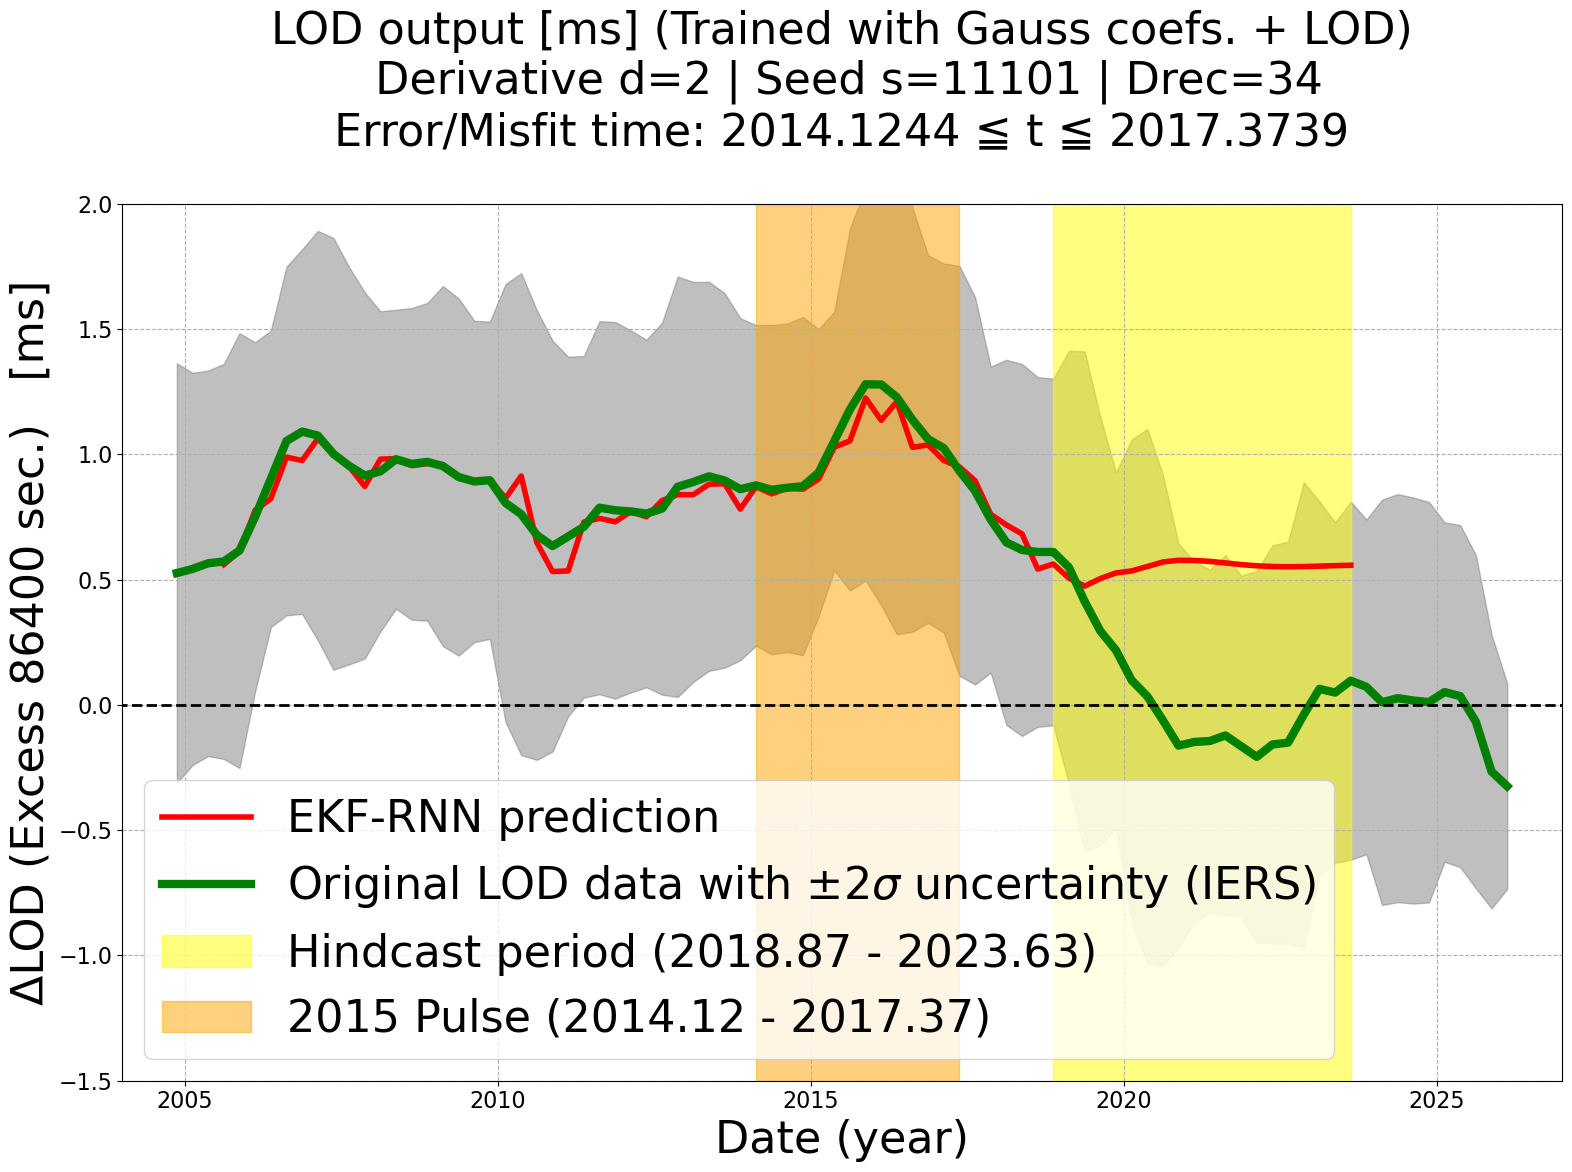

In [147]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))



ax.plot(yLOD['time_memo'], yLOD['d2g_memo'][-1, :], 
        color="red", linewidth=4.0,
        label="EKF-RNN prediction") # RNN prediction of LOD)

LOD_raw = pd.read_csv(f"{mcm_load}/lod.csv")
print(LOD_raw.head())

LOD_raw.set_index('YEAR', inplace=True)

ax.plot(LOD_raw.index.values, LOD_raw['avg_lod'].values,
        color="green", linewidth=6.0,
        label="Original LOD data with $\pm 2σ$ uncertainty (IERS)") # RNN prediction of LOD)

ax.fill_between(LOD_raw.index.values, 
                LOD_raw['avg_lod'].values - sig * LOD_raw['std_lod'].values,
                LOD_raw['avg_lod'].values + sig * LOD_raw['std_lod'].values,
                color='gray', alpha=0.5)

ymin, ymax = -1.5, 2.0
ax.set_ylim(ymin, ymax)

ax.fill_between(nLOD['time_memo'], ymin, ymax, 
            where=(nLOD['time_memo']>=fS) & (nLOD['time_memo']<=fE), 
            color='yellow', alpha=0.5, label=f'Hindcast period ({fS:.2f} - {fE:.2f})')
ax.fill_between(nLOD['time_memo'], ymin, ymax, 
            where=(nLOD['time_memo']>=TS-0.2502) & (nLOD['time_memo']<=TE-0.2502), 
            color='orange', alpha=0.5, label=f'2015 Pulse ({TS-0.25:.2f} - {TE-0.25:.2f})')

ax.plot([2000, 2030], [0, 0], 'k--', linewidth=2.0)
ax.set_xlim(2004, 2027)

ax.set_xlabel('Date (year)', fontsize=f_large)
ax.set_ylabel("ΔLOD (Excess 86400 sec.)   [ms]", fontsize=f_large)
ax.set_title(r"LOD output [ms] (Trained with Gauss coefs. + LOD)" + 
        f"\n Derivative d={diff} | Seed s=11101 | Drec=34" + 
        f"\n Error/Misfit time: {TS-0.2502:.4f} ≦ t ≦ {TE-0.2502:.4f} \n", 
        fontsize=f_large)
ax.legend(fontsize=f_large, loc='lower left')
plt.tight_layout()
plt.show()

        YEAR  avg_lod  std_lod
0 2004.87390  0.52648  0.41865
1 2005.12370  0.54272  0.39144
2 2005.37390  0.56549  0.38475
3 2005.62410  0.57278  0.39421
4 2005.87420  0.61620  0.43387


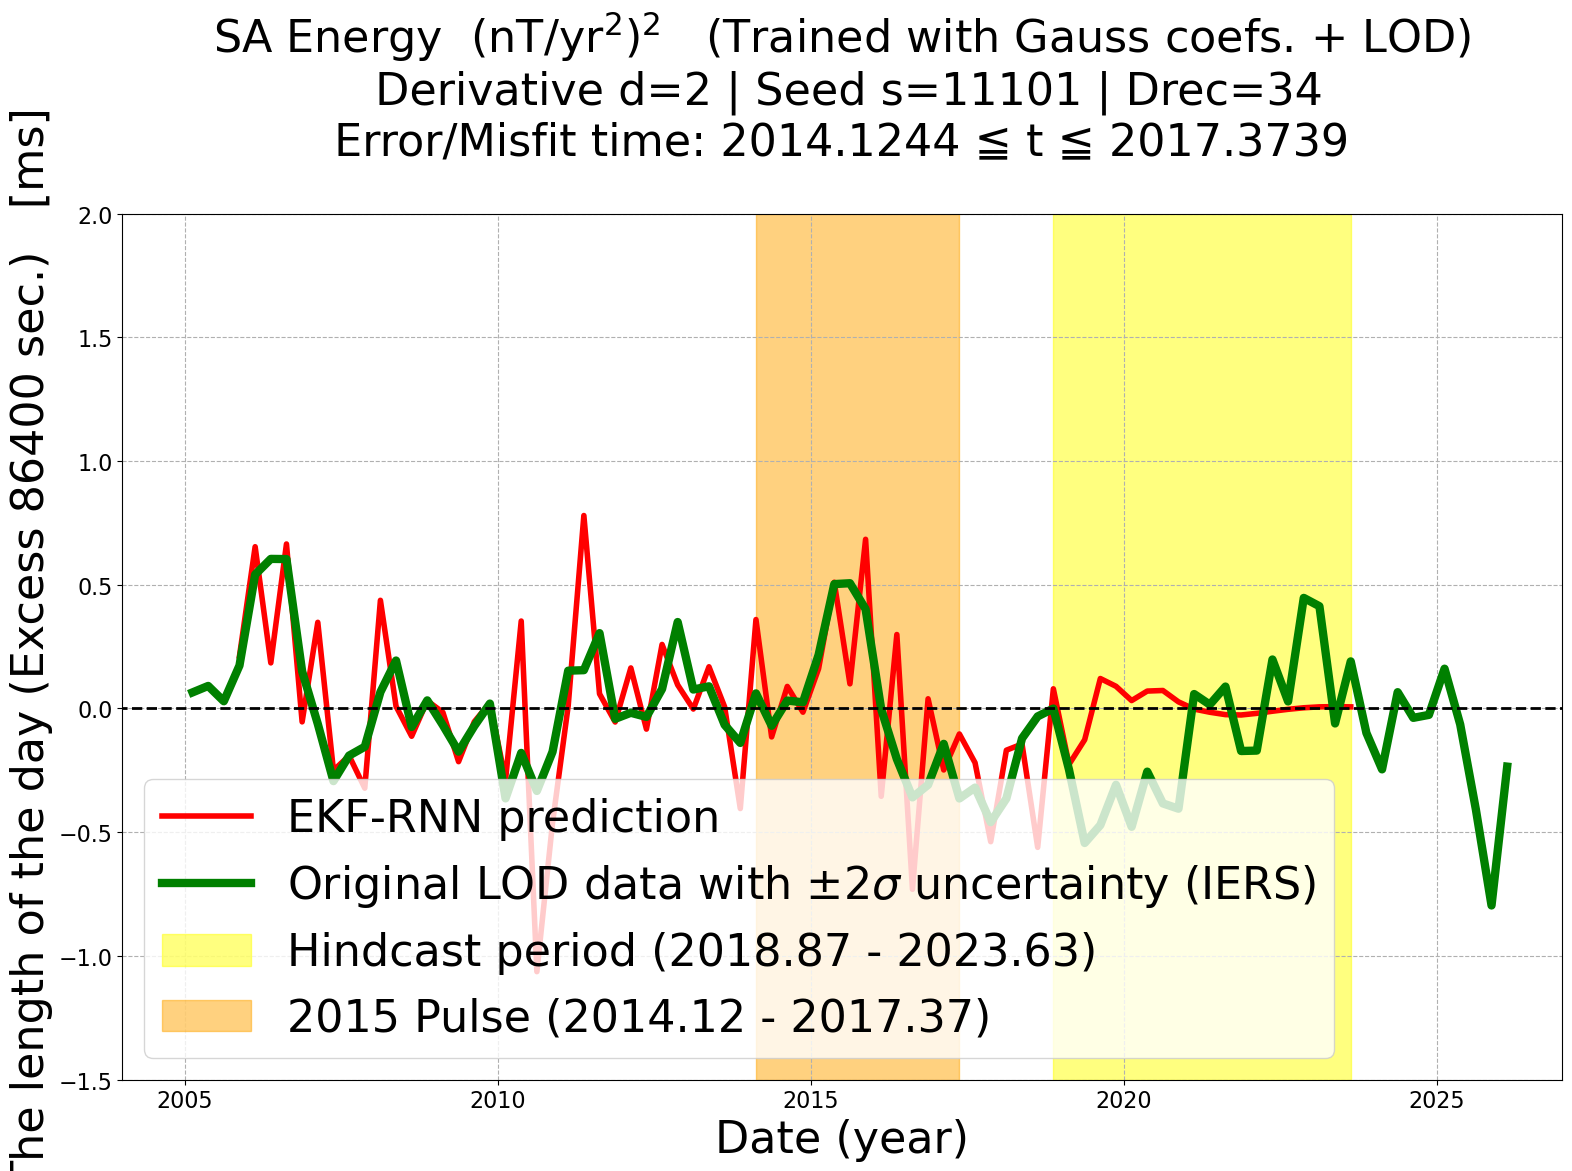

In [148]:
#d(lod)/dt

fig, ax = plt.subplots(1, 1, figsize=(16, 12))

ax.plot(yLOD['time_memo'][1:], np.diff(yLOD['d2g_memo'][-1, :]) / dt, 
        color="red", linewidth=4.0,
        label="EKF-RNN prediction") # RNN prediction of LOD)

LOD_raw = pd.read_csv(f"{mcm_load}/lod.csv")
print(LOD_raw.head())

LOD_raw.set_index('YEAR', inplace=True)

ax.plot(LOD_raw.index.values, LOD_raw['avg_lod'].diff().values / dt,
        color="green", linewidth=6.0,
        label="Original LOD data with $\pm 2σ$ uncertainty (IERS)") # RNN prediction of LOD)

ymin, ymax = -1.5, 2.0
ax.set_ylim(ymin, ymax)

ax.fill_between(nLOD['time_memo'], ymin, ymax, 
            where=(nLOD['time_memo']>=fS) & (nLOD['time_memo']<=fE), 
            color='yellow', alpha=0.5, label=f'Hindcast period ({fS:.2f} - {fE:.2f})')
ax.fill_between(nLOD['time_memo'], ymin, ymax, 
            where=(nLOD['time_memo']>=TS-0.2502) & (nLOD['time_memo']<=TE-0.2502), 
            color='orange', alpha=0.5, label=f'2015 Pulse ({TS-0.25:.2f} - {TE-0.25:.2f})')

ax.plot([2000, 2030], [0, 0], 'k--', linewidth=2.0)
ax.set_xlim(2004, 2027)

ax.set_xlabel('Date (year)', fontsize=f_large)
ax.set_ylabel("The length of the day (Excess 86400 sec.)   [ms]", fontsize=f_large)
ax.set_title(r"SA Energy  (nT/yr$^2$)$^2$   (Trained with Gauss coefs. + LOD)" + 
        f"\n Derivative d={diff} | Seed s=11101 | Drec=34" + 
        f"\n Error/Misfit time: {TS-0.2502:.4f} ≦ t ≦ {TE-0.2502:.4f} \n", 
        fontsize=f_large)
ax.legend(fontsize=f_large, loc='lower left')
plt.tight_layout()
plt.show()

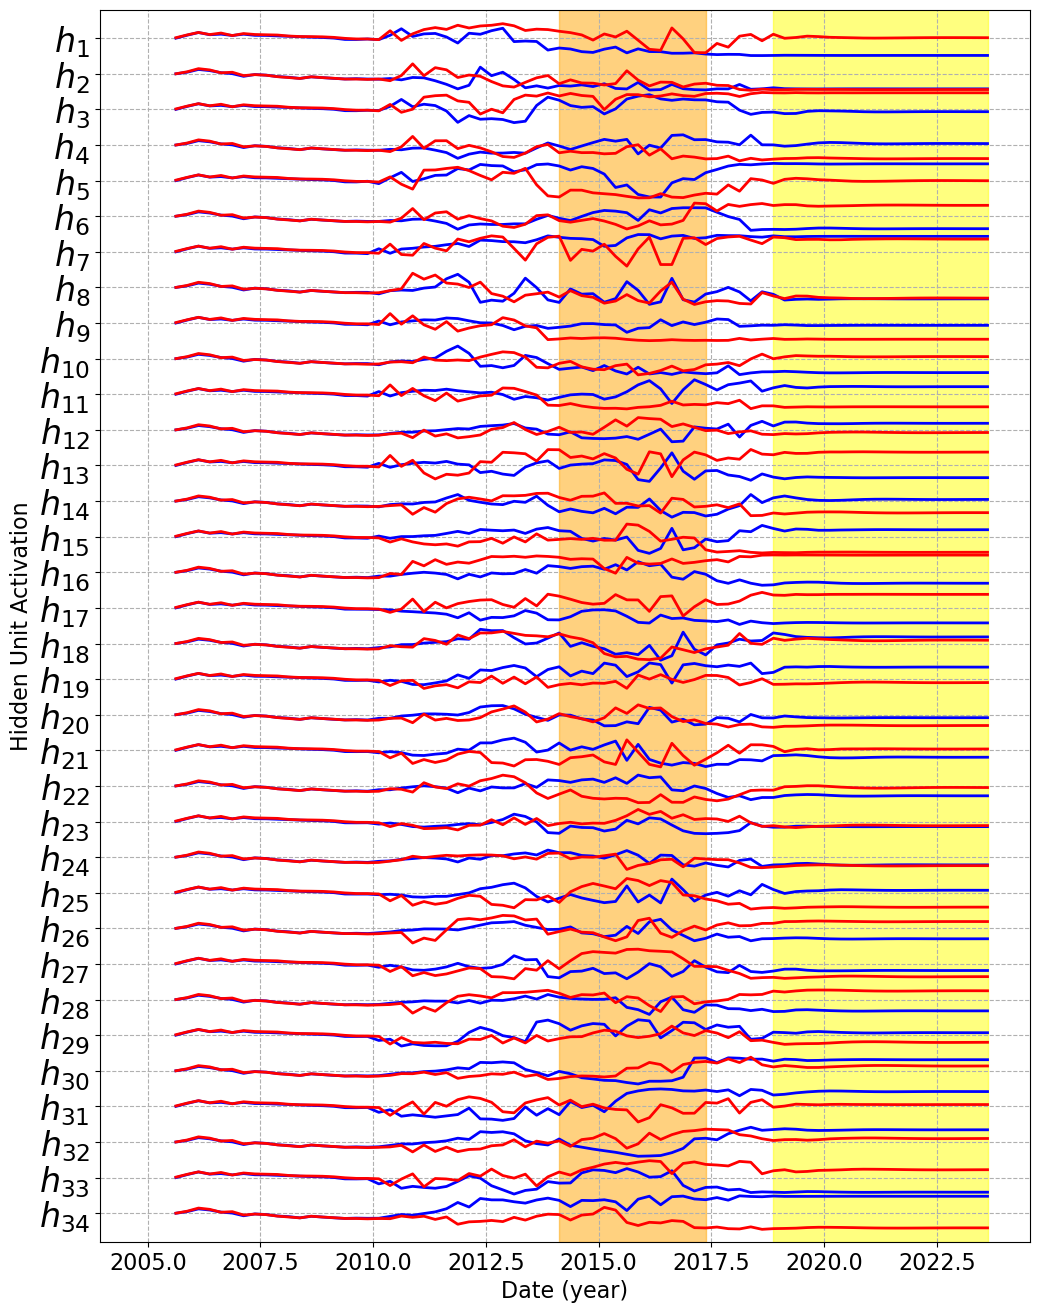

In [149]:
## Hidden layer states

fig, ax = plot_ht(nLOD["ht_memo"], nLOD['time_memo'], color="blue", fontsize=f_medium)

fig, ax = plot_ht(yLOD["ht_memo"], yLOD['time_memo'], color="red", fontsize=f_medium, fig_ax=(fig, ax))

ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin, ymax)

ax.fill_between(nLOD['time_memo'], ymin, ymax, 
            where=(nLOD['time_memo']>=fS) & (nLOD['time_memo']<=fE), 
            color='yellow', alpha=0.5, label=f'Hindcast period ({fS:.2f} - {fE:.2f})')
ax.fill_between(nLOD['time_memo'], ymin, ymax, 
            where=(nLOD['time_memo']>=TS-0.2502) & (nLOD['time_memo']<=TE-0.2502), 
            color='orange', alpha=0.5, label=f'2015 Pulse ({TS-0.25:.2f} - {TE-0.25:.2f})')
plt.show()